In [1]:
# General imports
import numpy as np
import qiskit
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import DensityMatrix, partial_trace
# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

In [2]:
# [Reference]: https://docs.quantum.ibm.com/guides/build-noise-models
# https://docs.quantum.ibm.com/guides/simulate-with-qiskit-aer

from qiskit_aer import AerSimulator

from qiskit_aer.primitives import SamplerV2 as Sampler
#from qiskit_ibm_runtime import SamplerV2 as Sampler
# from qiskit.primitives import StatevectorSampler
# sampler = StatevectorSampler()
sampler = Sampler()


from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer.noise import (NoiseModel,QuantumError,ReadoutError,depolarizing_error,pauli_error,thermal_relaxation_error)
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
# YOUR_API_TOKEN = "a44932650c6324c729fbd156e2808cff2dc96cc78fdaf3058a5e3583edfadad4acf73471140788f0efa7ed71a98f1e13069af52fe115e4e0e2bb868ab0be5d70"
# QiskitRuntimeService.save_account(channel="ibm_quantum", token= YOUR_API_TOKEN, overwrite = True)
# service = QiskitRuntimeService()
# backend = service.backend("ibm_brisbane")
# noise_model = NoiseModel.from_backend(backend)

In [3]:
from scipy.sparse import csr_matrix
from scipy.sparse import csr_matrix, kron
from numpy import trace

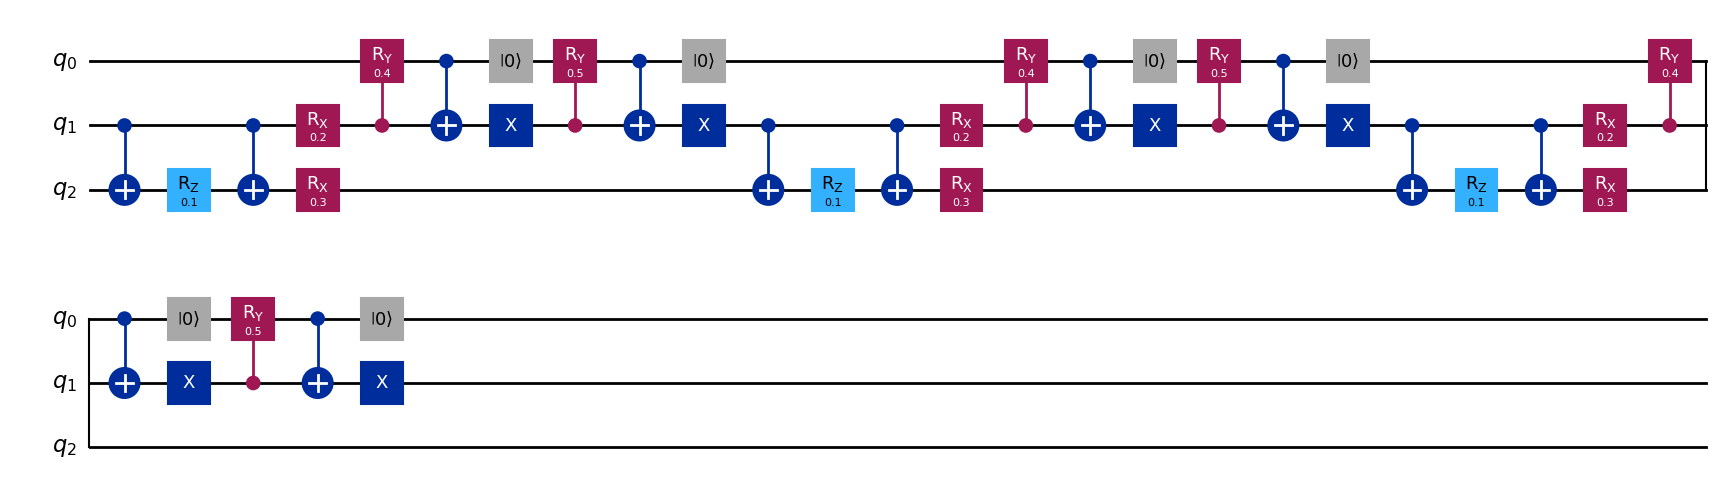

In [6]:
# VQA circuit.
from qiskit import QuantumCircuit, transpile

I = np.array([[1,0],[0,1]])
sigma_x = np.array([[0,1],[1,0]])
sigma_y = np.array([[0,-1j],[1j,0]])
sigma_z = np.array([[1,0],[0,-1]])

"""
The TFIM for L = 2 is given by: H = J * (Z_1 * Z_2) + h * (X_1 + X_2). We will consider
the two jump operators: L_1 = sqrt(g_1) * (X_1 - i * Y_1} and L_2 = sqrt(g_2) * (X_2 - i Y_2).

"""

# The variational circuit is just the trotter circuit for the TFIM.
n_qubits = 2
def anstaz_circuit(angles_lst, number_of_layers):  

     number_of_angles_per_layer = 4

     if len(angles_lst*number_of_angles_per_layer) % number_of_layers != 0:
         raise ValueError("The number of angles should be divisible by the number of layers.")
     else:
           anstaz_circuit = QuantumCircuit(n_qubits+1)
           for i in range(number_of_layers):
               # Hamiltonian part.
               anstaz_circuit.cx(1,2)
               anstaz_circuit.rz(angles_lst[i][0], 2)
               anstaz_circuit.cx(1,2)
               anstaz_circuit.rx(angles_lst[i][1], 1)
               anstaz_circuit.rx(angles_lst[i][2], 2)
               # Jump operator part.
               anstaz_circuit.cry(angles_lst[i][3], 1, 0)
               anstaz_circuit.cx(0,1)
               anstaz_circuit.reset(0)
               anstaz_circuit.x(1)
               anstaz_circuit.cry(angles_lst[i][4], 1, 0)
               anstaz_circuit.cx(0,1)
               anstaz_circuit.x(1)
               anstaz_circuit.reset(0)
     return anstaz_circuit      

anstaz_circuit([[0.1, 0.2, 0.3, 0.4, 0.5], [0.1, 0.2, 0.3, 0.4, 0.5], [0.1, 0.2, 0.3, 0.4, 0.5]], 3).draw("mpl", scale = 1)     

In [8]:
J = 1.0
h = 0.5
gamma_1 = 1
gamma_2 = 0.5

def lindblad_equation(rho):
     """
     The Lindblad equation for the density matrix rho is given by: d rho / dt = -i [H, rho] + sum_i (L_i rho L_i^dagger - 0.5 {L_i^dagger L_i, rho}).
     """
     # Define the Hamiltonian.
     H = 1j * J * (np.kron(sigma_z, sigma_z) + h * (np.kron(sigma_x, I) + np.kron(I, sigma_x)))
     # Define the jump operators.
     L_1 = np.sqrt(gamma_1) * (np.kron(sigma_x, I) - 1j * np.kron(sigma_y, I))
     L_2 = np.sqrt(gamma_2) * (np.kron(I, sigma_x) - 1j * np.kron(I, sigma_y))
     # Define the Lindblad equation.
     d_rho_dt = -1j * (np.dot(H, rho) - np.dot(rho, H)) + np.dot(L_1, np.dot(rho, np.conj(L_1).T)) + np.dot(L_2, np.dot(rho, np.conj(L_2).T)) - 0.5 * (np.dot(np.conj(L_1).T, np.dot(L_1, rho)) + np.dot(np.conj(L_2).T, np.dot(L_2, rho)))
     return d_rho_dt 

In [9]:
def return_density_matrix(quantum_circuit):

     quantum_circuit.save_density_matrix()  # Save the density matrix

     # Step 2: Simulate the circuit
     simulator = AerSimulator()  # Aer simulator supports reset gates
     quantum_circuit = transpile(quantum_circuit, simulator)
     result = simulator.run(quantum_circuit).result()
     # Step 3: Extract the density matrix
     rho_full = DensityMatrix(result.data()["density_matrix"])

     # Step 4: Compute the reduced density matrix for the second qubit
     rho_1 = partial_trace(rho_full, [0])  # Trace out qubit 0
     rho_1_matrix = rho_1.data

     return rho_1_matrix

In [10]:
def cost_function(rho):
     L_rho = lindblad_equation(rho)
     return np.real(np.trace(L_rho.conj().T@L_rho))

In [24]:
tolerance_for_convergence = 1.e-2
# Random initial angle parameters.
# Layer 1.
theta_11 = np.random.uniform(0, 2*np.pi)
theta_12 = np.random.uniform(0, 2*np.pi)
theta_13 = np.random.uniform(0, 2*np.pi)
theta_14 = np.random.uniform(0, 2*np.pi)
theta_15 = np.random.uniform(0, 2*np.pi)
# Layer 2.
theta_21 = np.random.uniform(0, 2*np.pi)
theta_22 = np.random.uniform(0, 2*np.pi)
theta_23 = np.random.uniform(0, 2*np.pi)
theta_24 = np.random.uniform(0, 2*np.pi)
theta_25 = np.random.uniform(0, 2*np.pi)
# Layer 3.
theta_31 = np.random.uniform(0, 2*np.pi)
theta_32 = np.random.uniform(0, 2*np.pi)
theta_33 = np.random.uniform(0, 2*np.pi)
theta_34 = np.random.uniform(0, 2*np.pi)
theta_35 = np.random.uniform(0, 2*np.pi)

theta_11_values = [theta_11]
theta_12_values = [theta_12]
theta_13_values = [theta_13]
theta_14_values = [theta_14]
theta_15_values = [theta_15]

theta_21_values = [theta_21]
theta_22_values = [theta_22]
theta_23_values = [theta_23]
theta_24_values = [theta_24]
theta_25_values = [theta_25]

theta_31_values = [theta_31]
theta_32_values = [theta_32]
theta_33_values = [theta_33]
theta_34_values = [theta_34]
theta_35_values = [theta_35]

initial_learning_rate = 1

number_of_layers = 3 # Number of layers in the VQA circuit.

number_of_iterations = 0
max_iterations = 100

best_cost = float("inf")
best_theta_11, best_theta_12, best_theta_13, best_theta_14, best_theta_15 = theta_11, theta_12, theta_13, theta_14, theta_15
best_theta_21, best_theta_22, best_theta_23, best_theta_24, best_theta_25 = theta_21, theta_22, theta_23, theta_24, theta_25
best_theta_31, best_theta_32, best_theta_33, best_theta_34, best_theta_35 = theta_31, theta_32, theta_33, theta_34, theta_35
best_iteration = 0

cost_function_values_lst = []

while number_of_iterations <= max_iterations:

     vqa_circuit = anstaz_circuit([[theta_11, theta_12, theta_13, theta_14, theta_15],
                                        [theta_21, theta_22, theta_23, theta_24, theta_25],
                                        [theta_31, theta_32, theta_33, theta_34, theta_35]], number_of_layers)
     rho = return_density_matrix(vqa_circuit)
     cost_value = cost_function(rho)
     cost_function_values_lst.append(cost_value)

     if cost_value < best_cost:
          best_cost = cost_value
          best_theta_11, best_theta_12, best_theta_13, best_theta_14, best_theta_15 = theta_11, theta_12, theta_13, theta_14, theta_15
          best_theta_21, best_theta_22, best_theta_23, best_theta_24, best_theta_25 = theta_21, theta_22, theta_23, theta_24, theta_25
          best_theta_31, best_theta_32, best_theta_33, best_theta_34, best_theta_35 = theta_31, theta_32, theta_33, theta_34, theta_35
          best_iteration = number_of_iterations
    
     if cost_value <= tolerance_for_convergence:
          print("\n[CONVERGED] Cost function is less than the tolerance value.\n")
          print("Cost function =", cost_value)
          print("Parameters =", theta_11, theta_12, theta_13, theta_14, theta_15, theta_21, theta_22, theta_23, theta_24, theta_25,
                theta_31, theta_32, theta_33, theta_34, theta_35)
          break

     # Decaying learning rate.
     learning_rate = initial_learning_rate / (1 + number_of_iterations)

     gradients = []

     # First layer.
     vqa_circuit_plus_theta_11 = anstaz_circuit([[theta_11 + np.pi/2, theta_12, theta_13, theta_14, theta_15],
                                                  [theta_21, theta_22, theta_23, theta_24, theta_25],
                                                  [theta_31, theta_32, theta_33, theta_34, theta_35]], number_of_layers)
     vqa_circuit_minus_theta_11 = anstaz_circuit([[theta_11 - np.pi/2, theta_12, theta_13, theta_14, theta_15],
                                                  [theta_21, theta_22, theta_23, theta_24, theta_25],
                                                  [theta_31, theta_32, theta_33, theta_34, theta_35]], number_of_layers)
     vqa_circuit_plus_theta_12 = anstaz_circuit([[theta_11, theta_12 + np.pi/2, theta_13, theta_14, theta_15],
                                                  [theta_21, theta_22, theta_23, theta_24, theta_25],
                                                  [theta_31, theta_32, theta_33, theta_34, theta_35]], number_of_layers)
     vqa_circuit_minus_theta_12 = anstaz_circuit([[theta_11, theta_12 - np.pi/2, theta_13, theta_14, theta_15],
                                                  [theta_21, theta_22, theta_23, theta_24, theta_25],
                                                  [theta_31, theta_32, theta_33, theta_34, theta_35]], number_of_layers)      
     vqa_circuit_plus_theta_13 = anstaz_circuit([[theta_11, theta_12, theta_13 + np.pi/2, theta_14, theta_15], 
                                                  [theta_21, theta_22, theta_23, theta_24, theta_25],
                                                  [theta_31, theta_32, theta_33, theta_34, theta_35]], number_of_layers)
     vqa_circuit_minus_theta_13 = anstaz_circuit([[theta_11, theta_12, theta_13 - np.pi/2, theta_14, theta_15],
                                                  [theta_21, theta_22, theta_23, theta_24, theta_25],
                                                  [theta_31, theta_32, theta_33, theta_34, theta_35]], number_of_layers)      
     vqa_circuit_plus_theta_14 = anstaz_circuit([[theta_11, theta_12, theta_13, theta_14 + np.pi/2, theta_15],
                                                  [theta_21, theta_22, theta_23, theta_24, theta_25],
                                                  [theta_31, theta_32, theta_33, theta_34, theta_35]], number_of_layers)
     vqa_circuit_minus_theta_14 = anstaz_circuit([[theta_11, theta_12, theta_13, theta_14 - np.pi/2, theta_15],
                                                  [theta_21, theta_22, theta_23, theta_24, theta_25],
                                                  [theta_31, theta_32, theta_33, theta_34, theta_35]], number_of_layers)
     vqa_circuit_plus_theta_15 = anstaz_circuit([[theta_11, theta_12, theta_13, theta_14, theta_15 + np.pi/2],
                                                  [theta_21, theta_22, theta_23, theta_24, theta_25],
                                                  [theta_31, theta_32, theta_33, theta_34, theta_35]], number_of_layers)
     vqa_circuit_minus_theta_15 = anstaz_circuit([[theta_11, theta_12, theta_13, theta_14, theta_15 - np.pi/2],
                                                  [theta_21, theta_22, theta_23, theta_24, theta_25],
                                                  [theta_31, theta_32, theta_33, theta_34, theta_35]], number_of_layers)  
    # Second layer.                                                    
     vqa_circuit_plus_theta_21 = anstaz_circuit([[theta_11, theta_12, theta_13, theta_14, theta_15],
                                                  [theta_21 + np.pi/2, theta_22, theta_23, theta_24, theta_25],
                                                  [theta_31, theta_32, theta_33, theta_34, theta_35]], number_of_layers)
     vqa_circuit_minus_theta_21 = anstaz_circuit([[theta_11, theta_12, theta_13, theta_14, theta_15],    
                                                  [theta_21 - np.pi/2, theta_22, theta_23, theta_24, theta_25],
                                                  [theta_31, theta_32, theta_33, theta_34, theta_35]], number_of_layers)
     vqa_circuit_plus_theta_22 = anstaz_circuit([[theta_11, theta_12, theta_13, theta_14, theta_15],
                                                  [theta_21, theta_22 + np.pi/2, theta_23, theta_24, theta_25],
                                                  [theta_31, theta_32, theta_33, theta_34, theta_35]], number_of_layers)
     vqa_circuit_minus_theta_22 = anstaz_circuit([[theta_11, theta_12, theta_13, theta_14, theta_15],
                                                  [theta_21, theta_22 - np.pi/2, theta_23, theta_24, theta_25],
                                                  [theta_31, theta_32, theta_33, theta_34, theta_35]], number_of_layers)
     vqa_circuit_plus_theta_23 = anstaz_circuit([[theta_11, theta_12, theta_13, theta_14, theta_15],
                                                  [theta_21, theta_22, theta_23 + np.pi/2, theta_24, theta_25],
                                                  [theta_31, theta_32, theta_33, theta_34, theta_35]], number_of_layers)
     vqa_circuit_minus_theta_23 = anstaz_circuit([[theta_11, theta_12, theta_13, theta_14, theta_15],
                                                  [theta_21, theta_22, theta_23 - np.pi/2, theta_24, theta_25],
                                                  [theta_31, theta_32, theta_33, theta_34, theta_35]], number_of_layers)
     vqa_circuit_plus_theta_24 = anstaz_circuit([[theta_11, theta_12, theta_13, theta_14, theta_15],
                                                  [theta_21, theta_22, theta_23, theta_24 + np.pi/2, theta_25],
                                                  [theta_31, theta_32, theta_33, theta_34, theta_35]], number_of_layers)
     vqa_circuit_minus_theta_24 = anstaz_circuit([[theta_11, theta_12, theta_13, theta_14, theta_15],
                                                  [theta_21, theta_22, theta_23, theta_24 - np.pi/2, theta_25],
                                                  [theta_31, theta_32, theta_33, theta_34, theta_35]], number_of_layers)
     vqa_circuit_plus_theta_25 = anstaz_circuit([[theta_11, theta_12, theta_13, theta_14, theta_15],
                                                  [theta_21, theta_22, theta_23, theta_24, theta_25 + np.pi/2],
                                                  [theta_31, theta_32, theta_33, theta_34, theta_35]], number_of_layers)
     vqa_circuit_minus_theta_25 = anstaz_circuit([[theta_11, theta_12, theta_13, theta_14, theta_15],
                                                  [theta_21, theta_22, theta_23, theta_24, theta_25 - np.pi/2],
                                                  [theta_31, theta_32, theta_33, theta_34, theta_35]], number_of_layers)
     # Third layer.
     vqa_circuit_plus_theta_31 = anstaz_circuit([[theta_11, theta_12, theta_13, theta_14, theta_15],
                                                  [theta_21, theta_22, theta_23, theta_24, theta_25],
                                                  [theta_31 + np.pi/2, theta_32, theta_33, theta_34, theta_35]], number_of_layers)
     vqa_circuit_minus_theta_31 = anstaz_circuit([[theta_11, theta_12, theta_13, theta_14, theta_15],
                                                  [theta_21, theta_22, theta_23, theta_24, theta_25],
                                                  [theta_31 - np.pi/2, theta_32, theta_33, theta_34, theta_35]], number_of_layers)
     vqa_circuit_plus_theta_32 = anstaz_circuit([[theta_11, theta_12, theta_13, theta_14, theta_15],
                                                  [theta_21, theta_22, theta_23, theta_24, theta_25],
                                                  [theta_31, theta_32 + np.pi/2, theta_33, theta_34, theta_35]], number_of_layers)
     vqa_circuit_minus_theta_32 = anstaz_circuit([[theta_11, theta_12, theta_13, theta_14, theta_15],
                                                  [theta_21, theta_22, theta_23, theta_24, theta_25],
                                                  [theta_31, theta_32 - np.pi/2, theta_33, theta_34, theta_35]], number_of_layers)
     vqa_circuit_plus_theta_33 = anstaz_circuit([[theta_11, theta_12, theta_13, theta_14, theta_15],
                                                  [theta_21, theta_22, theta_23, theta_24, theta_25],
                                                  [theta_31, theta_32, theta_33 + np.pi/2, theta_34, theta_35]], number_of_layers)
     vqa_circuit_minus_theta_33 = anstaz_circuit([[theta_11, theta_12, theta_13, theta_14, theta_15],
                                                  [theta_21, theta_22, theta_23, theta_24, theta_25],
                                                  [theta_31, theta_32, theta_33 - np.pi/2, theta_34, theta_35]], number_of_layers)
     vqa_circuit_plus_theta_34 = anstaz_circuit([[theta_11, theta_12, theta_13, theta_14, theta_15],
                                                  [theta_21, theta_22, theta_23, theta_24, theta_25],
                                                  [theta_31, theta_32, theta_33, theta_34 + np.pi/2, theta_35]], number_of_layers)
     vqa_circuit_minus_theta_34 = anstaz_circuit([[theta_11, theta_12, theta_13, theta_14, theta_15],
                                                  [theta_21, theta_22, theta_23, theta_24, theta_25],
                                                  [theta_31, theta_32, theta_33, theta_34 - np.pi/2, theta_35]], number_of_layers)
     vqa_circuit_plus_theta_35 = anstaz_circuit([[theta_11, theta_12, theta_13, theta_14, theta_15],
                                                  [theta_21, theta_22, theta_23, theta_24, theta_25],
                                                  [theta_31, theta_32, theta_33, theta_34, theta_35 + np.pi/2]], number_of_layers)
     vqa_circuit_minus_theta_35 = anstaz_circuit([[theta_11, theta_12, theta_13, theta_14, theta_15],
                                                  [theta_21, theta_22, theta_23, theta_24, theta_25],
                                                  [theta_31, theta_32, theta_33, theta_34, theta_35 - np.pi/2]], number_of_layers)


     gradient_theta_11 = (cost_function(return_density_matrix(vqa_circuit_plus_theta_11)) - cost_function(return_density_matrix(vqa_circuit_minus_theta_11))) / 2
     gradient_theta_12 = (cost_function(return_density_matrix(vqa_circuit_plus_theta_12)) - cost_function(return_density_matrix(vqa_circuit_minus_theta_12))) / 2
     gradient_theta_13 = (cost_function(return_density_matrix(vqa_circuit_plus_theta_13)) - cost_function(return_density_matrix(vqa_circuit_minus_theta_13))) / 2
     gradient_theta_14 = (cost_function(return_density_matrix(vqa_circuit_plus_theta_14)) - cost_function(return_density_matrix(vqa_circuit_minus_theta_14))) / 2
     gradient_theta_15 = (cost_function(return_density_matrix(vqa_circuit_plus_theta_15)) - cost_function(return_density_matrix(vqa_circuit_minus_theta_15))) / 2

     gradient_theta_21 = (cost_function(return_density_matrix(vqa_circuit_plus_theta_21)) - cost_function(return_density_matrix(vqa_circuit_minus_theta_21))) / 2
     gradient_theta_22 = (cost_function(return_density_matrix(vqa_circuit_plus_theta_22)) - cost_function(return_density_matrix(vqa_circuit_minus_theta_22))) / 2
     gradient_theta_23 = (cost_function(return_density_matrix(vqa_circuit_plus_theta_23)) - cost_function(return_density_matrix(vqa_circuit_minus_theta_23))) / 2
     gradient_theta_24 = (cost_function(return_density_matrix(vqa_circuit_plus_theta_24)) - cost_function(return_density_matrix(vqa_circuit_minus_theta_24))) / 2
     gradient_theta_25 = (cost_function(return_density_matrix(vqa_circuit_plus_theta_25)) - cost_function(return_density_matrix(vqa_circuit_minus_theta_25))) / 2

     gradient_theta_31 = (cost_function(return_density_matrix(vqa_circuit_plus_theta_31)) - cost_function(return_density_matrix(vqa_circuit_minus_theta_31))) / 2
     gradient_theta_32 = (cost_function(return_density_matrix(vqa_circuit_plus_theta_32)) - cost_function(return_density_matrix(vqa_circuit_minus_theta_32))) / 2
     gradient_theta_33 = (cost_function(return_density_matrix(vqa_circuit_plus_theta_33)) - cost_function(return_density_matrix(vqa_circuit_minus_theta_33))) / 2
     gradient_theta_34 = (cost_function(return_density_matrix(vqa_circuit_plus_theta_34)) - cost_function(return_density_matrix(vqa_circuit_minus_theta_34))) / 2
     gradient_theta_35 = (cost_function(return_density_matrix(vqa_circuit_plus_theta_35)) - cost_function(return_density_matrix(vqa_circuit_minus_theta_35))) / 2


     # Parameter update.
     theta_11 = theta_11 - learning_rate * gradient_theta_11
     theta_12 = theta_12 - learning_rate * gradient_theta_12
     theta_13 = theta_13 - learning_rate * gradient_theta_13
     theta_14 = theta_14 - learning_rate * gradient_theta_14
     theta_15 = theta_15 - learning_rate * gradient_theta_15

     theta_21 = theta_21 - learning_rate * gradient_theta_21
     theta_22 = theta_22 - learning_rate * gradient_theta_22
     theta_23 = theta_23 - learning_rate * gradient_theta_23
     theta_24 = theta_24 - learning_rate * gradient_theta_24
     theta_25 = theta_25 - learning_rate * gradient_theta_25

     theta_31 = theta_31 - learning_rate * gradient_theta_31
     theta_32 = theta_32 - learning_rate * gradient_theta_32
     theta_33 = theta_33 - learning_rate * gradient_theta_33
     theta_34 = theta_34 - learning_rate * gradient_theta_34
     theta_35 = theta_35 - learning_rate * gradient_theta_35

     theta_11_values.append(theta_11)
     theta_12_values.append(theta_12)
     theta_13_values.append(theta_13)
     theta_14_values.append(theta_14)
     theta_15_values.append(theta_15)

     theta_21_values.append(theta_21)
     theta_22_values.append(theta_22)
     theta_23_values.append(theta_23)
     theta_24_values.append(theta_24)
     theta_25_values.append(theta_25)

     theta_31_values.append(theta_31)
     theta_32_values.append(theta_32)
     theta_33_values.append(theta_33)
     theta_34_values.append(theta_34)
     theta_35_values.append(theta_35)

     number_of_iterations += 1
     print("Cost function =", cost_value)
     print("Number of iterations =", number_of_iterations)
     print("Learning rate =", learning_rate)

     if number_of_iterations == max_iterations:
          print("\n[NOT CONVERGED] Maximum number of iterations reached.\n")
          print("Best cost function =", best_cost)
          print("Best parameters =", best_theta_11, best_theta_12, best_theta_13, best_theta_14, best_theta_15, best_theta_21, best_theta_22, best_theta_23, best_theta_24, best_theta_25, best_theta_31, best_theta_32, best_theta_33, best_theta_34, best_theta_35)    
          print("Best iteration =", best_iteration)
          break

Cost function = 1.987565049473567
Number of iterations = 1
Learning rate = 1.0
Cost function = 5.283562263169465
Number of iterations = 2
Learning rate = 0.5
Cost function = 11.947890052661975
Number of iterations = 3
Learning rate = 0.3333333333333333
Cost function = 12.182395998685593
Number of iterations = 4
Learning rate = 0.25
Cost function = 6.108891823524862
Number of iterations = 5
Learning rate = 0.2
Cost function = 1.072338280058387
Number of iterations = 6
Learning rate = 0.16666666666666666
Cost function = 1.5018151773376611
Number of iterations = 7
Learning rate = 0.14285714285714285
Cost function = 8.190201640983753
Number of iterations = 8
Learning rate = 0.125
Cost function = 16.35498859188433
Number of iterations = 9
Learning rate = 0.1111111111111111
Cost function = 2.9280224507014925
Number of iterations = 10
Learning rate = 0.1
Cost function = 4.807898389894093
Number of iterations = 11
Learning rate = 0.09090909090909091
Cost function = 7.3515593542706945
Number of

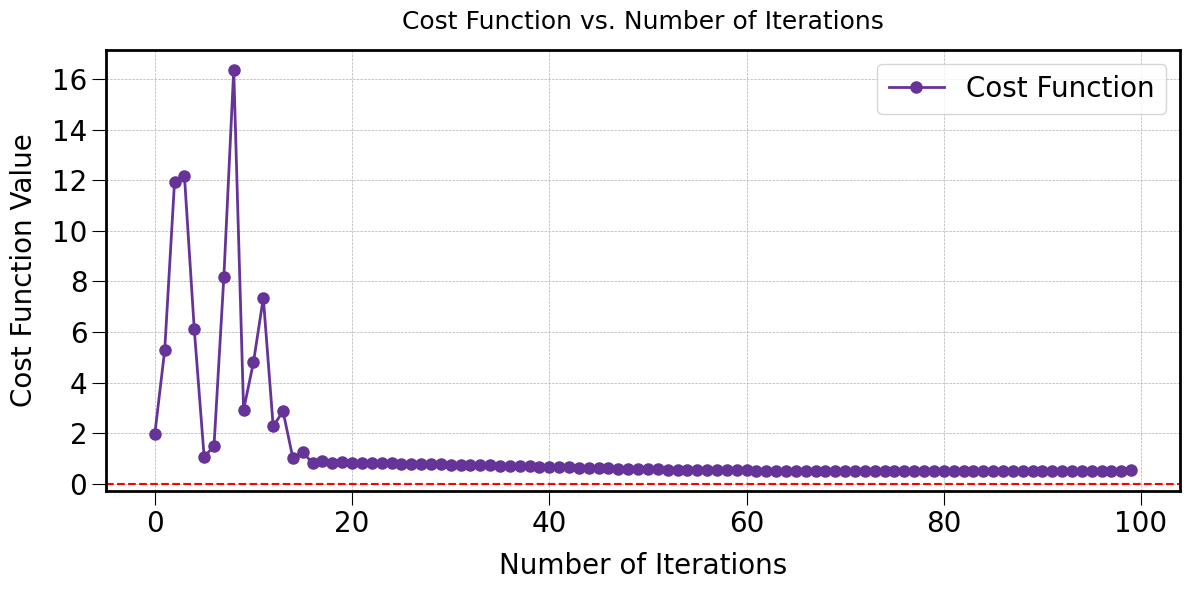

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(cost_function_values_lst)), cost_function_values_lst, marker="o", linestyle='-', color="rebeccapurple", linewidth=2, markersize=8, label="Cost Function")

plt.xlabel("Number of Iterations", fontsize=20, labelpad=10)
plt.ylabel("Cost Function Value", fontsize=20, labelpad=10)
plt.title("Cost Function vs. Number of Iterations", fontsize=18, pad=15)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.axhline(y=0, color="r", linestyle="--")

# Get current axis
ax = plt.gca()
# Make axis lines thicker
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

# Make ticks longer
ax.tick_params(axis='both', which='major', length=10)
plt.tight_layout()
plt.show()